## Análisis exploratorio y evaluación de calidad de datos

In [21]:
import os

# Parte de donde sea que esté el CWD actualmente
d = os.getcwd()

# Subir hasta encontrar la carpeta "Entregable"
while os.path.basename(d) != "Entregable":
    parent = os.path.dirname(d)
    if parent == d:   # Llegó al disco sin encontrar Entregable
        raise RuntimeError("No se encontró la carpeta Entregable hacia arriba.")
    d = parent

os.chdir(d)
print("CWD fijado en:", os.getcwd())

CWD fijado en: c:\Users\Mariana\Dropbox\Cursos\SoyHenry\DataEngineering\Modulo02-ModeladoDeDatosYBDRelacionales\ProyectoIntegrador\Entregable


In [22]:
# Conexión a la base de datos
import pandas as pd
from sqlalchemy import text
from src.database.connection import DB

engine = DB.engine()

def q(sql):
    return pd.read_sql(text(sql), engine)

print("Conexión a la base de datos exitosa")


Conexión a la base de datos exitosa


In [23]:
# Función universal para leer tablas del schema staging
def df_table(table_name, schema="staging", limit=None):
    sql = f"SELECT * FROM {schema}.{table_name}"
    if limit:
        sql += f" LIMIT {limit}"
    return pd.read_sql(text(sql), engine)

## Exploración con SQL

In [5]:
q("SELECT tablename FROM pg_tables WHERE schemaname='staging'")

,tablename
0,usuarios
1,categorias
2,productos
3,ordenes
4,detalle_ordenes
5,direcciones_envio
6,carrito
7,metodos_pago
8,ordenes_metodos_pago
9,resenas_productos


In [6]:
# Contar filas por tabla

schema = 'staging'
df = q(f"SELECT tablename FROM pg_tables WHERE schemaname='{schema}'")

tables = df["tablename"].tolist()

for t in tables:
    print(t, q(f"SELECT COUNT(*) FROM {schema}.{t};").iloc[0,0])

usuarios 1000
categorias 12
productos 36
ordenes 10000
detalle_ordenes 10000
direcciones_envio 1000
carrito 5000
metodos_pago 7
ordenes_metodos_pago 10000
resenas_productos 7172
historial_pagos 10000


### No se encuentran tablas vacías.

In [7]:
# Exploración con Python / ORM

from src.database.models import (
    Usuario, Producto, Categoria, Orden, DetalleOrden,
    DireccionEnvio, MetodoPago, OrdenMetodoPago,
    ResenaProducto, HistorialPago, Carrito
)
from sqlalchemy.orm import Session

session = Session(engine)

In [8]:
# Verificar el diseño de los usuarios

usuarios = session.query(Usuario).limit(10).all()
[(u.id, u.nombre, u.email) for u in usuarios]

[(1, 'Encarna', 'encarna.donaire1@correo.com'),
 (2, 'Jose Ignacio', 'jose ignacio.canales2@correo.com'),
 (3, 'José', 'josé.sebastián3@correo.com'),
 (4, 'Priscila', 'priscila.vilar4@correo.com'),
 (5, 'Epifanio', 'epifanio.ríos5@correo.com'),
 (6, 'Cipriano', 'cipriano.sastre6@correo.com'),
 (7, 'Gerónimo', 'gerónimo.alcalá7@correo.com'),
 (8, 'Odalis', 'odalis.estévez8@correo.com'),
 (9, 'Clara', 'clara.prada9@correo.com'),
 (10, 'Azahara', 'azahara.espada10@correo.com')]

In [ ]:
# Verificar el diseño de los productos

productos = session.query(Producto).limit(10).all()
[(u.id, u.nombre) for u in productos]

## Búsqueda de datos nulos

In [9]:
def null_report(table):
    df = df_table(table)
    total = len(df)

    rep = pd.DataFrame({
        "columna": df.columns,
        "nulos": df.isna().sum().values,
        "porcentaje": (df.isna().mean() * 100).round(2).values
    })

    rep["tabla"] = table
    return rep[["tabla", "columna", "nulos", "porcentaje"]]

# Generar un único dataframe para todas las tablas
nulls_all = pd.concat([null_report(t) for t in tables], ignore_index=True)

nulls_all

,tabla,columna,nulos,porcentaje
0,usuarios,id,0,0.0
1,usuarios,nombre,0,0.0
2,usuarios,apellido,0,0.0
3,usuarios,dni,0,0.0
4,usuarios,email,0,0.0
5,usuarios,contrasena,0,0.0
6,categorias,id,0,0.0
7,categorias,nombre,0,0.0
8,categorias,descripcion,0,0.0
9,productos,id,0,0.0


No hay nulos en las tablas

## Búsqueda de duplicados

In [10]:
# Usuarios con DNI duplicados

schema = "staging"
q(f"""
SELECT dni, COUNT(*) 
FROM {schema}.usuarios
GROUP BY dni
HAVING COUNT(*) > 1
""")


,dni,count


No hay usuarios con DNI duplicados

In [11]:
# Productos por nombre y categoría

q(f"""
SELECT nombre, categoria_id, COUNT(*)
FROM {schema}.productos
GROUP BY nombre, categoria_id
HAVING COUNT(*) > 1
""")



,nombre,categoria_id,count


No hay duplicados de productos dentro de una misma categoría

## Valores atípicos

In [12]:
# Precios negativos o extremadamente altos

q(f"""
SELECT id, nombre, precio
FROM {schema}.productos
WHERE precio < 0 OR precio > 1000000;
""")

,id,nombre,precio


No hay precios negaitivos ni muy altos

In [13]:
# Stock negativo

q(f"""
SELECT * FROM {schema}.productos WHERE stock < 0;
""")

,id,nombre,descripcion,precio,stock,categoria_id


No hay valores de stock negativo

## Inconsistencia entre tablas

In [14]:
# Órdenes que hacen referencia a usuarios que no existen

q(f"""
SELECT o.*
FROM {schema}.ordenes o
LEFT JOIN {schema}.usuarios u ON u.id = o.usuario_id
WHERE u.id IS NULL;
""")


,id,usuario_id,fecha_orden,total,estado


In [15]:
# Detalle de orden sin producto asociado

q(f"""
SELECT d.*
FROM {schema}.detalle_ordenes d
LEFT JOIN {schema}.productos p ON p.id = d.producto_id
WHERE p.id IS NULL;
""")


,id,orden_id,producto_id,cantidad,precio_unitario


In [16]:
# Órdenes con método de pago inexistente

q(f"""
SELECT omp.*
FROM {schema}.ordenes_metodos_pago omp
LEFT JOIN {schema}.metodos_pago mp ON mp.id = omp.metodo_pago_id
WHERE mp.id IS NULL;
""")


,id,orden_id,metodo_pago_id,monto_pagado


In [17]:
# Reseñas de usuarios inexistentes

q(f"""
SELECT r.*
FROM {schema}.resenas_productos r
LEFT JOIN {schema}.usuarios u ON u.id = r.usuario_id
WHERE u.id IS NULL;
""")


,id,usuario_id,producto_id,calificacion,comentario,fecha


In [25]:
# Usuarios sin dirección de envío

q(f"""
SELECT u.*
FROM {schema}.usuarios u
LEFT JOIN {schema}.direcciones_envio d ON u.id = d.usuario_id
WHERE u.id IS NULL;
""")

,id,nombre,apellido,dni,email,contrasena


In [26]:
# Verificar si coinciden el total de la orden 
# con la suma del producto de precio por cantidad de cada producto
# de la tabla detalle_ordenes

q(f"""
with total_detalles as
(
	select orden_id, sum(cantidad * precio_unitario) as total_detalle
	from {schema}.detalle_ordenes
	group by orden_id
)
select o.id, o.total as total_orden, d.total_detalle
from {schema}.ordenes o
inner join total_detalles d on o.id = d.orden_id
where total <> total_detalle;
""")

,id,total_orden,total_detalle
0,1,393.81,7616.92
1,2,918.85,5947.39
2,3,391.29,6215.59
3,4,250.03,4389.87
4,5,983.13,8351.20
...,...,...,...
995,996,721.14,8792.55
996,997,467.19,3701.23
997,998,804.10,14144.48
998,999,990.13,10805.60


## Visualización de algunos valores con gráficos

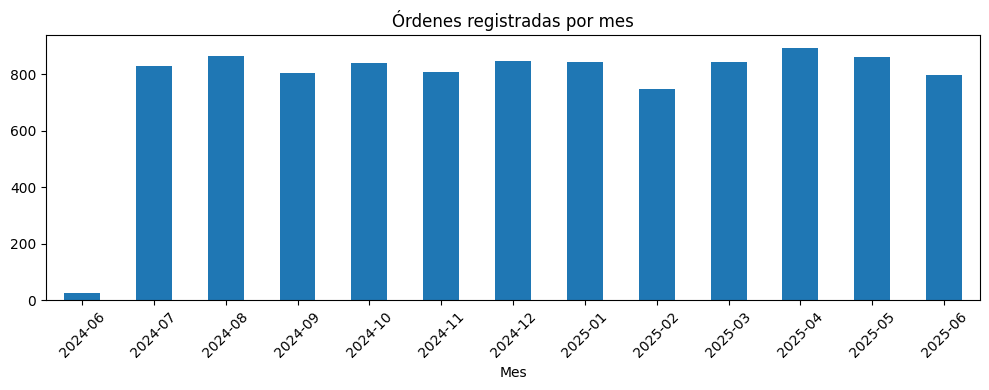

In [19]:
# Cantidad de órdenes por mes

from sqlalchemy.orm import Session
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt

cmap = plt.get_cmap("viridis")

session = Session(engine)

# 1. Traer órdenes desde el ORM
ordenes = session.query(Orden).all()

# 2. Convertir a DataFrame
df_ordenes = pd.DataFrame([
    {"OrdenID": o.id, "FechaOrden": o.fecha_orden}
    for o in ordenes
])

# 3. Convertir fechas
df_ordenes["FechaOrden"] = pd.to_datetime(df_ordenes["FechaOrden"])

# 4. Extraer año-mes
df_ordenes["Mes"] = df_ordenes["FechaOrden"].dt.to_period("M")

# 5. Agrupar
ordenes_por_mes = df_ordenes.groupby("Mes").size()

# 6. Plot tipo SoyHenry
ordenes_por_mes.plot(
    kind="bar",
    title="Órdenes registradas por mes",
    figsize=(10,4),
    rot=45
)

plt.tight_layout()
plt.show()



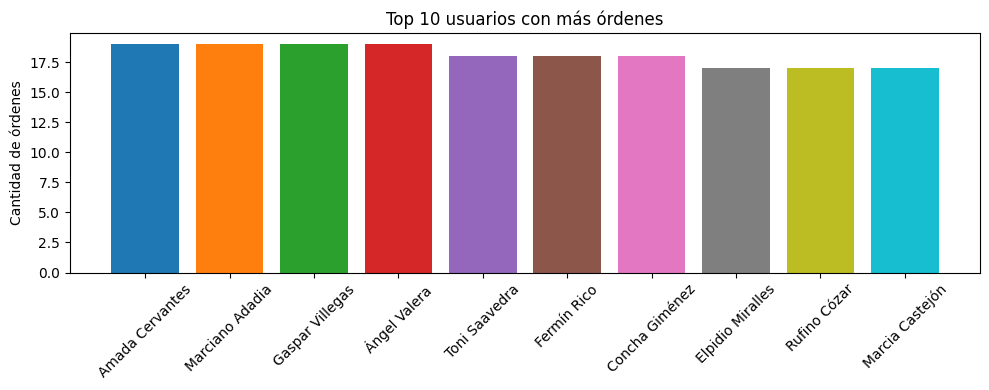

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy.orm import Session

# --- 1. Traer datos desde ORM ---
session = Session(engine)

ordenes = (
    session.query(Orden, Usuario)
    .join(Usuario, Orden.usuario_id == Usuario.id)
    .all()
)

# --- 2. Convertir a DataFrame ---
df = pd.DataFrame([
    {
        "OrdenID": o.id,
        "UsuarioID": u.id,
        "Nombre": u.nombre,
        "Apellido": u.apellido
    }
    for o, u in ordenes
])

# --- 3. Agrupar: Top 10 usuarios con más órdenes ---
top_usuarios = (
    df.groupby(["UsuarioID", "Nombre", "Apellido"])
      .size()
      .reset_index(name="CantidadOrdenes")
      .sort_values("CantidadOrdenes", ascending=False)
      .head(10)
)

# --- 4. Gráfico con colores distintos ---
plt.figure(figsize=(10,4))

# Elegimos una paleta (podés usar tab10, viridis, plasma, Set3, etc.)
cmap = plt.cm.tab10  
colors = cmap(np.linspace(0, 1, len(top_usuarios)))

plt.bar(
    top_usuarios["Nombre"] + " " + top_usuarios["Apellido"],
    top_usuarios["CantidadOrdenes"],
    color=colors
)

plt.xticks(rotation=45)
plt.title("Top 10 usuarios con más órdenes")
plt.ylabel("Cantidad de órdenes")
plt.tight_layout()
plt.show()
